## 8. Portfolio Construction using the Kelly Criterion

In this section, we will utilize the Kelly criterion to construct a portfolio based on three assets: Bitcoin (BTC), Gold (XAU), and the VN-Index (VNI). This portfolio construction will employ two commonly used trading strategies in financial markets: Momentum and Mean Reversion. Specifically, these strategies will be implemented using the Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Keltner Channels (KC) indicators.

### 8.1 Overview of Trading Strategies

#### Indicators:

* **RSI (Relative Strength Index):**
    The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally, and in this study (using a 14-period RSI), the RSI is considered overbought when above 70 and oversold when below 30. These levels can indicate an impending price correction or rebound. Divergences between RSI and price action can also signal potential trend reversals.

* **MACD (Moving Average Convergence Divergence):**
    The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of an asset's price. The MACD is calculated by subtracting the 26-period EMA from the 12-period EMA. A 9-period EMA of the MACD, called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. The difference between the MACD and its signal line is often plotted as a histogram.

* **Keltner Channels (KC):**
    Keltner Channels are volatility-based bands placed above and below an asset's price. The channels are typically set as a multiple of the Average True Range (ATR) above and below an Exponential Moving Average (EMA) of the price. The middle line is an EMA of the price (e.g., 20-period EMA). The upper band is calculated as EMA + (Multiplier \* ATR), and the lower band is EMA - (Multiplier \* ATR). These channels can help identify overbought and oversold conditions, as well as potential breakouts when the price moves outside the channels.

#### Combining Indicators to Create Trading Strategies:

* **RSI and MACD (Momentum Strategy):**
    This combined RSI-MACD strategy uses RSI (14-period) and MACD (12-period fast EMA, 26-period slow EMA, 9-period signal line) to identify buy and sell signals.
    * **Buy Signal:** A buy signal is generated when the RSI is above 30 (indicating it's not deeply oversold, or moving out of oversold territory) AND the MACD line crosses above its signal line.
    * **Sell Signal:** Conversely, a sell signal occurs when the RSI is below 70 (indicating it's not deeply overbought, or moving out of overbought territory) AND the MACD line crosses below its signal line.
    This strategy leverages both momentum (RSI) and trend-following (MACD crossover) indicators for potentially more reliable trading decisions.

* **RSI and Keltner Channels (Mean Reversion Strategy):**
    This strategy combines RSI (14-period) with Keltner Channels (e.g., 20-period EMA for the middle line, 10-period ATR, and a multiplier of 2 for the bands) to identify potential price reversions.
    * **Buy Signal:** A buy signal is generated when the price touches or breaks below the lower Keltner Channel AND the RSI indicates an oversold condition (e.g., RSI ≤ 30).
    * **Sell Signal:** A sell signal occurs when the price touches or breaks above the upper Keltner Channel AND the RSI indicates an overbought condition (e.g., RSI ≥ 70).
    The rationale is that when the price reaches an extreme relative to its recent volatility (indicated by Keltner Channels) and momentum is also at an extreme (indicated by RSI), a reversion towards the mean is more likely.

### 8.2 What is the Kelly Criterion?

The Kelly Criterion is a mathematical formula used to determine the optimal size of a series of bets or investments to maximize long-term logarithmic wealth. Developed by John L. Kelly Jr. while working at Bell Labs, it was originally designed to analyze noise issues in long-distance telephone signals but was quickly adopted by gamblers and investors.

The formula for the Kelly fraction ($f^*$), representing the proportion of current capital to allocate to a particular opportunity, is:

$f^* = p - \frac{(1-p)}{b} = \frac{pb - (1-p)}{b}$

Where:
* $f^*$ is the fraction of the current capital to bet or invest.
* $p$ is the probability of winning (Winning Rate).
* $b$ is the decimal odds received on the wager (i.e., if you bet \$1 and win, you receive $b$ dollars in profit; $b$ = Average Win / Average Loss).



### 8.3 Settings Before Running Trading Algorithm:

1.  **Total Budget for Investment:** 1,000,000,000 VND (One billion Vietnamese Dong).
2.  **Kelly Parameter Calculation Period:** The Kelly criterion parameters (`p` - winning rate, and `b` - decimal odds) are calculated using historical data from January 1, 2015, to January 1, 2023. These calculated parameters are then held constant and applied throughout the subsequent backtesting period, which runs from January 2, 2023, to May 10, 2025. (This approach differs from a rolling Kelly calculation and uses a fixed set of parameters derived from the specified training period).
3.  **Currency Conversion:** As the three assets (XAU, BTC, VNI) are not denominated in the same currency, USD/VND exchange rate data covering the entire period (e.g., January 1, 2015, to May 10, 2025) is utilized for all transactions and portfolio valuation in VND. BTC and XAU prices, originally in USD, are converted to VND using the daily exchange rate.
4.  **VNI Trading Convention:** Trading the VN-Index is assumed to be analogous to trading VN30 futures contracts. The value of one VNI contract point is set at 100,000 VND. For example, if the VNI is at 1200 points, one "contract" (representing 1 point for simplicity in this model) would be valued at 1200 \* 100,000 VND = 120,000,000 VND. More precisely, the value of a position in VNI is `number_of_VNI_points_held * current_VNI_index_value * 100,000 VND`.
5.  **Minimum Tradeable Units:**
    * BTC: 0.0001 BTC
    * XAU: 0.01 XAU (typically one ounce or a fraction thereof)
    * VNI: 0.01 "points" (representing a fraction of the index value for trading purposes).
6.  **Trading Direction:** To simplify the backtesting process, only long positions are initiated. No short selling is permitted.
7.  **Risk-Free Rate ($R_f$):** A risk-free rate of 3.1% per annum, approximating the 10-year Vietnamese government bond yield, is used for calculating performance metrics such as the Sharpe Ratio.

### 8.4 Coding and main function

#### 8.4.1 Import library and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting y-axis as percentage
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, KeltnerChannel # Thêm KeltnerChannel
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid') # A visually appealing style

# %%
# --- Cấu hình ---
INITIAL_CAPITAL = 1_000_000_000  # 1 tỷ VND
VNI_POINT_MULTIPLIER = 100_000  # 1 điểm VNI = 100,000 VND

# Khối lượng giao dịch tối thiểu
MIN_TRADE_BTC = 0.0001
MIN_TRADE_XAU = 0.01
MIN_TRADE_VNI_CONTRACTS = 0.01 # 0.01 "điểm" VNI (hoặc "hợp đồng nhỏ")

# Đường dẫn tới thư mục chứa dữ liệu gốc (cleaned data)
DATA_PATH = r"C:\Users\Admin\Desktop\Big Data Final\Group_3_Final_Project-main\Data/"

# Ngày cho giai đoạn huấn luyện (tính p, b) và giai đoạn backtest
TRAIN_START_DATE = "2015-01-01" 
TRAIN_END_DATE = "2023-01-01"   
BACKTEST_START_DATE = "2023-01-02" 
BACKTEST_END_DATE = "2025-05-10"   # Ngày kết thúc backtest mới

# Tham số cho chỉ báo kỹ thuật
RSI_PERIOD = 14
MACD_FAST_PERIOD = 12
MACD_SLOW_PERIOD = 26
MACD_SIGNAL_PERIOD = 9
# BB_WINDOW = 20 # Không còn dùng BB trực tiếp trong chiến lược chính
# BB_STD_DEV = 2   
KC_WINDOW_EMA = 20 # Chu kỳ EMA cho Keltner Channel
KC_WINDOW_ATR = 10 # Chu kỳ ATR cho Keltner Channel
KC_MULTIPLIER = 2  # Hệ số nhân ATR cho Keltner Channel

# Tỷ lệ phi rủi ro hàng năm cho Sharpe Ratio
ANNUAL_RISK_FREE_RATE = 0.031 # 3.1%

# %% [markdown]
# ## Phần 2: Tải và Tiền xử lý Dữ liệu (Từ các file _cleaned.csv)

# %%
def load_and_preprocess_cleaned_data(data_path, vni_multiplier):
    """
    Tải dữ liệu giá từ các file *_cleaned.csv, hợp nhất với tỷ giá USDVND.
    Các file _cleaned.csv cần có cột 'Date', 'Price', 'Open', 'High', 'Low', 'Vol'.
    """
    asset_files_info = {
        'BTC': {'file': 'BTC_cleaned.csv', 
                'cols_original': ['Price', 'Open', 'High', 'Low', 'Vol'],
                'internal_cols': ['BTC_Price_USD', 'BTC_Open_USD', 'BTC_High_USD', 'BTC_Low_USD', 'BTC_Volume']},
        'XAU': {'file': 'XAU_cleaned.csv',
                'cols_original': ['Price', 'Open', 'High', 'Low', 'Vol'],
                'internal_cols': ['XAU_Price_USD', 'XAU_Open_USD', 'XAU_High_USD', 'XAU_Low_USD', 'XAU_Volume']},
        'VNI': {'file': 'VNI_cleaned.csv',
                'cols_original': ['Price', 'Open', 'High', 'Low', 'Vol'],
                'internal_cols': ['VNI_Points', 'VNI_Open_Points', 'VNI_High_Points', 'VNI_Low_Points', 'VNI_Volume']}
    }
    
    all_data_frames = []

    for asset_prefix, info in asset_files_info.items():
        try:
            df_asset = pd.read_csv(data_path + info['file'], parse_dates=['Date'])
            
            # Kiểm tra sự tồn tại của các cột gốc
            missing_original_cols = [col for col in info['cols_original'] if col not in df_asset.columns]
            if missing_original_cols:
                print(f"Cảnh báo: File {info['file']} cho {asset_prefix} thiếu cột: {', '.join(missing_original_cols)}. Bỏ qua tài sản này.")
                continue
            
            current_asset_cols = ['Date'] + info['cols_original']
            df_asset_processed = df_asset[current_asset_cols].copy()

            # Đảm bảo các cột là numeric trước khi đổi tên
            for col_original in info['cols_original']:
                if df_asset_processed[col_original].dtype == 'object':
                    df_asset_processed[col_original] = df_asset_processed[col_original].astype(str).str.replace(',', '', regex=False)
                df_asset_processed[col_original] = pd.to_numeric(df_asset_processed[col_original], errors='coerce')
            
            rename_map = dict(zip(info['cols_original'], info['internal_cols']))
            df_asset_processed.rename(columns=rename_map, inplace=True)
            
            df_asset_processed.set_index('Date', inplace=True)
            all_data_frames.append(df_asset_processed)

        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy tệp {data_path + info['file']}. Bỏ qua tài sản {asset_prefix}.")
        except Exception as e:
            print(f"Lỗi khi đọc file {info['file']} cho {asset_prefix}: {e}")

    if not all_data_frames:
        print("Không tải được bất kỳ file dữ liệu tài sản nào.")
        return None
            
    try:
        df_usdvnd = pd.read_csv(data_path + "USD_VND_exchange_rate.csv", parse_dates=['Date'])
        if 'Price' not in df_usdvnd.columns:
            print(f"Lỗi: File tỷ giá USD_VND_exchange_rate.csv thiếu cột 'Price'.")
            return None
        
        if df_usdvnd['Price'].dtype == 'object':
            df_usdvnd['Price'] = df_usdvnd['Price'].astype(str).str.replace(',', '', regex=False)
        df_usdvnd['Price'] = pd.to_numeric(df_usdvnd['Price'], errors='coerce')

        df_usdvnd = df_usdvnd[['Date', 'Price']].rename(columns={'Price': 'USDVND'}).set_index('Date')
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy tệp tỷ giá {data_path + 'USD_VND_exchange_rate.csv'}.")
        return None
    except Exception as e:
        print(f"Lỗi khi đọc file tỷ giá: {e}")
        return None

    df_merged = df_usdvnd[['USDVND']] 
    for df_asset_item in all_data_frames:
        df_merged = df_merged.join(df_asset_item, how='outer')

    df_merged = df_merged.sort_index()
    df_merged['USDVND'] = df_merged['USDVND'].ffill().bfill() 

    # Chuyển đổi giá BTC và XAU sang VND (sử dụng cột giá đóng cửa _Price_USD)
    if 'BTC_Price_USD' in df_merged.columns:
        df_merged['BTC_Price_USD'] = pd.to_numeric(df_merged['BTC_Price_USD'], errors='coerce')
    if 'XAU_Price_USD' in df_merged.columns:
        df_merged['XAU_Price_USD'] = pd.to_numeric(df_merged['XAU_Price_USD'], errors='coerce')
    if 'USDVND' in df_merged.columns: 
        df_merged['USDVND'] = pd.to_numeric(df_merged['USDVND'], errors='coerce')

    if 'BTC_Price_USD' in df_merged.columns and 'USDVND' in df_merged.columns:
        df_merged['BTC_Price_VND'] = df_merged['BTC_Price_USD'] * df_merged['USDVND']
    if 'XAU_Price_USD' in df_merged.columns and 'USDVND' in df_merged.columns:
        df_merged['XAU_Price_VND'] = df_merged['XAU_Price_USD'] * df_merged['USDVND']
    
    df_merged.ffill(inplace=True)
    df_merged.bfill(inplace=True)

    print("Tải và tiền xử lý dữ liệu từ các file _cleaned.csv hoàn tất.")
    if not df_merged.empty:
        print(f"Dữ liệu từ {df_merged.index.min()} đến {df_merged.index.max()}")
    else:
        print("Không có dữ liệu sau khi hợp nhất.")
    return df_merged

# %%
# Thực thi tải dữ liệu
raw_data_merged = load_and_preprocess_cleaned_data(
    data_path=DATA_PATH,
    vni_multiplier=VNI_POINT_MULTIPLIER
)

if raw_data_merged is not None and not raw_data_merged.empty:
    print("\nXem thử 5 dòng dữ liệu đầu tiên (đã hợp nhất và xử lý giá):")
    print(raw_data_merged.head())
else:
    print("Không thể tải hoặc xử lý dữ liệu. Vui lòng kiểm tra lỗi và đường dẫn.")

# %% [markdown]
# ## Phần 3: Tính toán các Chỉ báo Kỹ thuật (Thêm Keltner Channels)

# %%
def calculate_technical_indicators(df):
    """
    Tính toán RSI, MACD, Keltner Channels cho mỗi tài sản.
    Input df phải chứa các cột giá gốc (ví dụ: BTC_Price_USD, BTC_High_USD, BTC_Low_USD, VNI_Points, etc.).
    """
    df_out = df.copy()
    
    # Cấu hình tài sản và cột giá gốc để tính chỉ báo
    # Giá trị là (tên cột giá đóng cửa, tên cột giá cao, tên cột giá thấp)
    assets_ohlc_cols = {
        'BTC': ('BTC_Price_USD', 'BTC_High_USD', 'BTC_Low_USD'), 
        'XAU': ('XAU_Price_USD', 'XAU_High_USD', 'XAU_Low_USD'),
        'VNI': ('VNI_Points', 'VNI_High_Points', 'VNI_Low_Points') 
    }

    for asset_prefix, (close_col, high_col, low_col) in assets_ohlc_cols.items():
        # Kiểm tra sự tồn tại của các cột cần thiết
        required_cols_for_asset = [close_col, high_col, low_col]
        missing_cols = [col for col in required_cols_for_asset if col not in df_out.columns or df_out[col].isnull().all()]
        
        if missing_cols:
            print(f"Cảnh báo: Thiếu cột giá ({', '.join(missing_cols)}) cho {asset_prefix} hoặc toàn NaN. Bỏ qua tính chỉ báo cho tài sản này.")
            for indicator_suffix in ['_RSI', '_MACD_Line', '_MACD_Signal', '_KC_Lower', '_KC_Upper', '_KC_Mid']:
                df_out[f'{asset_prefix}{indicator_suffix}'] = np.nan
            continue

        # Đảm bảo các series giá là numeric
        close_series = pd.to_numeric(df_out[close_col], errors='coerce')
        high_series = pd.to_numeric(df_out[high_col], errors='coerce')
        low_series = pd.to_numeric(df_out[low_col], errors='coerce')

        if close_series.isnull().all() or high_series.isnull().all() or low_series.isnull().all(): 
            print(f"Cảnh báo: Dữ liệu giá cho {asset_prefix} trở thành toàn NaN sau khi ép kiểu số. Bỏ qua tính chỉ báo.")
            for indicator_suffix in ['_RSI', '_MACD_Line', '_MACD_Signal', '_KC_Lower', '_KC_Upper', '_KC_Mid']:
                df_out[f'{asset_prefix}{indicator_suffix}'] = np.nan
            continue

        # RSI (dựa trên giá đóng cửa)
        rsi_indicator = RSIIndicator(close=close_series, window=RSI_PERIOD, fillna=False)
        df_out[f'{asset_prefix}_RSI'] = rsi_indicator.rsi()

        # MACD (dựa trên giá đóng cửa)
        macd_indicator = MACD(close=close_series, 
                              window_slow=MACD_SLOW_PERIOD, 
                              window_fast=MACD_FAST_PERIOD, 
                              window_sign=MACD_SIGNAL_PERIOD, 
                              fillna=False)
        df_out[f'{asset_prefix}_MACD_Line'] = macd_indicator.macd()
        df_out[f'{asset_prefix}_MACD_Signal'] = macd_indicator.macd_signal()

        # Keltner Channels (cần high, low, close)
        kc_indicator = KeltnerChannel(high=high_series, 
                                      low=low_series, 
                                      close=close_series, 
                                      window=KC_WINDOW_EMA, # EMA period for center line
                                      window_atr=KC_WINDOW_ATR, # ATR period
                                      multiplier=KC_MULTIPLIER, # ATR multiplier
                                      fillna=False)
        df_out[f'{asset_prefix}_KC_Upper'] = kc_indicator.keltner_channel_hband()
        df_out[f'{asset_prefix}_KC_Lower'] = kc_indicator.keltner_channel_lband()
        df_out[f'{asset_prefix}_KC_Mid'] = kc_indicator.keltner_channel_mband() # Đường giữa (EMA)
            
    indicator_cols = [col for col in df_out.columns if '_RSI' in col or '_MACD_' in col or '_KC_' in col]
    if indicator_cols:
      df_out[indicator_cols] = df_out[indicator_cols].fillna(method='bfill')
      df_out[indicator_cols] = df_out[indicator_cols].fillna(method='ffill')

    print("Tính toán các chỉ báo kỹ thuật (bao gồm Keltner Channels) hoàn tất.")
    return df_out

# %%
if raw_data_merged is not None and not raw_data_merged.empty:
    data_with_indicators = calculate_technical_indicators(raw_data_merged.copy()) 
    if data_with_indicators is not None:
        print("\nXem thử 5 dòng dữ liệu sau khi tính chỉ báo:")
        print(data_with_indicators.head())
        # print(data_with_indicators[['BTC_Price_USD', 'BTC_RSI', 'BTC_MACD_Line', 'BTC_KC_Lower', 'BTC_KC_Upper']].head(25))
    else:
        data_with_indicators = None 
else:
    data_with_indicators = None 

Tải và tiền xử lý dữ liệu từ các file _cleaned.csv hoàn tất.
Dữ liệu từ 2015-01-01 00:00:00 đến 2025-05-10 00:00:00

Xem thử 5 dòng dữ liệu đầu tiên (đã hợp nhất và xử lý giá):
             USDVND  BTC_Price_USD  BTC_Open_USD  BTC_High_USD  BTC_Low_USD  \
Date                                                                          
2015-01-01  21370.0          314.9         318.2         321.4        313.5   
2015-01-02  21370.0          315.2         314.9         316.4        313.1   
2015-01-03  21370.0          287.1         315.2         315.8        284.9   
2015-01-04  21370.0          264.7         287.1         289.9        255.9   
2015-01-05  21370.0          274.8         264.7         278.3        262.9   

            BTC_Volume  XAU_Price_USD  XAU_Open_USD  XAU_High_USD  \
Date                                                                
2015-01-01     12820.0         1186.2        1184.0        1194.9   
2015-01-02     14730.0         1186.2        1184.0        119

#### 8.4.2 Gennerating trading signal

In [2]:
def generate_signals_rsi_macd(df, asset_prefix):
    signals = pd.DataFrame(index=df.index)
    price_col_for_kelly = ''
    if asset_prefix == 'VNI': price_col_for_kelly = f'{asset_prefix}_Points' 
    elif f'{asset_prefix}_Price_VND' in df.columns: price_col_for_kelly = f'{asset_prefix}_Price_VND'
    elif f'{asset_prefix}_Price_USD' in df.columns and asset_prefix != 'VNI': price_col_for_kelly = f'{asset_prefix}_Price_USD'
    if not price_col_for_kelly or price_col_for_kelly not in df.columns or df[price_col_for_kelly].isnull().all():
        signals['Signal'] = 0; return signals.assign(Price_for_Kelly=np.nan) 
    signals['Price_for_Kelly'] = df[price_col_for_kelly]
    rsi_col = f'{asset_prefix}_RSI'; macd_line_col = f'{asset_prefix}_MACD_Line'; macd_signal_col = f'{asset_prefix}_MACD_Signal'
    required_indicator_cols = [rsi_col, macd_line_col, macd_signal_col]
    missing_cols = [col for col in required_indicator_cols if col not in df.columns or df[col].isnull().all()]
    if missing_cols: signals['Signal'] = 0; return signals 
    buy_condition = (df[rsi_col] > 30) & (df[macd_line_col] > df[macd_signal_col]) & (df[macd_line_col].shift(1) <= df[macd_signal_col].shift(1))
    sell_condition = (df[rsi_col] < 70) & (df[macd_line_col] < df[macd_signal_col]) & (df[macd_line_col].shift(1) >= df[macd_signal_col].shift(1))
    signals['Signal'] = 0; signals.loc[buy_condition, 'Signal'] = 1; signals.loc[sell_condition, 'Signal'] = -1
    return signals 

def generate_signals_rsi_kc(df, asset_prefix): # Đổi tên hàm và logic
    """Tạo tín hiệu Mua/Bán dựa trên RSI và Keltner Channels đã được tính toán."""
    signals = pd.DataFrame(index=df.index)

    price_col_for_kelly = ''
    if asset_prefix == 'VNI':
        price_col_for_kelly = f'{asset_prefix}_Points'
    elif f'{asset_prefix}_Price_VND' in df.columns:
        price_col_for_kelly = f'{asset_prefix}_Price_VND'
    elif f'{asset_prefix}_Price_USD' in df.columns and asset_prefix != 'VNI':
        price_col_for_kelly = f'{asset_prefix}_Price_USD'

    if not price_col_for_kelly or price_col_for_kelly not in df.columns or df[price_col_for_kelly].isnull().all():
        signals['Signal'] = 0
        return signals.assign(Price_for_Kelly=np.nan)
    signals['Price_for_Kelly'] = df[price_col_for_kelly]

    # Giá đóng cửa dùng để so sánh với Keltner Channels
    # Đây là giá gốc mà KC và RSI được tính trên đó
    price_for_kc_col = f'{asset_prefix}_Price_USD' if asset_prefix != 'VNI' else f'{asset_prefix}_Points'
    
    if price_for_kc_col not in df.columns or df[price_for_kc_col].isnull().all():
         signals['Signal'] = 0
         return signals 

    rsi_col = f'{asset_prefix}_RSI'
    kc_lower_col = f'{asset_prefix}_KC_Lower' # Sử dụng cột Keltner Channel
    kc_upper_col = f'{asset_prefix}_KC_Upper' # Sử dụng cột Keltner Channel

    required_indicator_cols_kc = [price_for_kc_col, rsi_col, kc_lower_col, kc_upper_col]
    missing_cols_kc = [col for col in required_indicator_cols_kc if col not in df.columns or df[col].isnull().all()]

    if missing_cols_kc:
        signals['Signal'] = 0
        return signals 
        
    # Tín hiệu MUA: Giá chạm hoặc phá xuống dưới dải Keltner dưới VÀ RSI <= 30
    buy_condition = (df[price_for_kc_col] <= df[kc_lower_col]) & (df[rsi_col] <= 30)
    
    # Tín hiệu BÁN: Giá chạm hoặc phá lên trên dải Keltner trên VÀ RSI >= 70
    sell_condition = (df[price_for_kc_col] >= df[kc_upper_col]) & (df[rsi_col] >= 70)

    signals['Signal'] = 0
    signals.loc[buy_condition, 'Signal'] = 1
    signals.loc[sell_condition, 'Signal'] = -1
    return signals 

# %%
if data_with_indicators is not None and not data_with_indicators.empty:
    print("\n--- Ví dụ tạo tín hiệu ---")
    btc_signals_rsi_macd = generate_signals_rsi_macd(data_with_indicators, 'BTC')
    if not btc_signals_rsi_macd.empty and 'Signal' in btc_signals_rsi_macd.columns:
        print("\nTín hiệu BTC (RSI+MACD):")
        print(btc_signals_rsi_macd[btc_signals_rsi_macd['Signal'] != 0].head())

    btc_signals_rsi_kc = generate_signals_rsi_kc(data_with_indicators, 'BTC') # Gọi hàm mới
    if not btc_signals_rsi_kc.empty and 'Signal' in btc_signals_rsi_kc.columns:
        print("\nTín hiệu BTC (RSI+KC):")
        print(btc_signals_rsi_kc[btc_signals_rsi_kc['Signal'] != 0].head())
else:
    print("Không thể tạo tín hiệu do `data_with_indicators` rỗng hoặc None.")



--- Ví dụ tạo tín hiệu ---

Tín hiệu BTC (RSI+MACD):
            Price_for_Kelly  Signal
Date                               
2015-01-27        5613556.0       1
2015-01-31        4646839.5      -1
2015-02-02        5065635.6       1
2015-02-05        4597161.0      -1
2015-02-07        4834526.4       1

Tín hiệu BTC (RSI+KC):
            Price_for_Kelly  Signal
Date                               
2015-01-03        6135327.0       1
2015-01-04        5656639.0       1
2015-01-05        5872476.0       1
2015-01-11        5650832.0       1
2015-01-12        5740129.5       1


#### 8.4.3 Calculating Kelly parameters

In [4]:
def calculate_kelly_parameters_buy_hold_sell(signals_df_with_price_for_kelly):
    if signals_df_with_price_for_kelly.empty or \
       'Signal' not in signals_df_with_price_for_kelly.columns or \
       'Price_for_Kelly' not in signals_df_with_price_for_kelly.columns or \
       signals_df_with_price_for_kelly['Price_for_Kelly'].isnull().all() or \
       signals_df_with_price_for_kelly['Signal'].eq(0).all(): 
        return 0, 1 
    trades = []; in_position = False; entry_price = 0
    valid_signals = signals_df_with_price_for_kelly.dropna(subset=['Price_for_Kelly', 'Signal'])
    for i in range(len(valid_signals)):
        current_signal = valid_signals['Signal'].iloc[i]; current_price = valid_signals['Price_for_Kelly'].iloc[i]
        if pd.isna(current_price): continue
        if not in_position and current_signal == 1: in_position = True; entry_price = current_price
        elif in_position and current_signal == -1:  
            if entry_price == 0: in_position = False; continue
            profit_loss_ratio = (current_price / entry_price) - 1; trades.append(profit_loss_ratio)
            in_position = False; entry_price = 0 
    if not trades: return 0, 1
    wins = [t for t in trades if t > 0]; losses = [t for t in trades if t < 0]
    if not wins or not losses:
        if not wins and not losses: return 0,1
        if not wins: p = 0
        else: p = len(wins) / len(trades)
        if not losses: b = 1000 
        else: b = 0.001 
        return p,b
    p = len(wins) / len(trades); avg_win = np.mean(wins); avg_loss = abs(np.mean(losses))
    if avg_loss == 0: b = 1000 
    else: b = avg_win / avg_loss
    if b <= 0: b = 0.001 
    return p, b

# %%
kelly_params_dict = {} 
strategies_for_kelly = { 
    'RSI_MACD': generate_signals_rsi_macd, 
    'RSI_KC': generate_signals_rsi_kc # Cập nhật chiến lược
}
if data_with_indicators is not None and not data_with_indicators.empty:
    train_data_for_kelly = data_with_indicators[(data_with_indicators.index >= TRAIN_START_DATE) & (data_with_indicators.index <= TRAIN_END_DATE)].copy()
    if not train_data_for_kelly.empty:
        assets_to_process = ['BTC', 'XAU', 'VNI']
        for asset in assets_to_process:
            kelly_params_dict[asset] = {}
            for strat_name, strat_func in strategies_for_kelly.items():
                print(f"Calculating Kelly params for {asset} - Strategy {strat_name}...")
                asset_signals_train_df = strat_func(train_data_for_kelly, asset) 
                if not asset_signals_train_df.empty and 'Signal' in asset_signals_train_df.columns and 'Price_for_Kelly' in asset_signals_train_df.columns and not asset_signals_train_df['Price_for_Kelly'].isnull().all(): 
                    p, b = calculate_kelly_parameters_buy_hold_sell(asset_signals_train_df) 
                    kelly_params_dict[asset][strat_name] = {'p': p, 'b': b}
                    print(f"  {asset} - {strat_name}: p={p:.4f}, b={b:.4f}")
                else:
                    print(f"  Could not generate signals or Price_for_Kelly is all NaN for {asset} - {strat_name} in training period. Setting default p,b.")
                    kelly_params_dict[asset][strat_name] = {'p': 0, 'b': 1}
        # print("\nKelly Parameters Calculated:") # Sẽ hiển thị ở bảng đẹp hơn sau
    else:
        print("No training data available in the selected date range for Kelly params calculation.")
else:
    print("`data_with_indicators` is empty or None. Cannot calculate Kelly params.")

Calculating Kelly params for BTC - Strategy RSI_MACD...
  BTC - RSI_MACD: p=0.4479, b=3.7623
Calculating Kelly params for BTC - Strategy RSI_KC...
  BTC - RSI_KC: p=0.7692, b=2.1977
Calculating Kelly params for XAU - Strategy RSI_MACD...
  XAU - RSI_MACD: p=0.3592, b=1.9149
Calculating Kelly params for XAU - Strategy RSI_KC...
  XAU - RSI_KC: p=0.8750, b=6.7939
Calculating Kelly params for VNI - Strategy RSI_MACD...
  VNI - RSI_MACD: p=0.5263, b=1.6374
Calculating Kelly params for VNI - Strategy RSI_KC...
  VNI - RSI_KC: p=0.6875, b=0.5053


#### 8.4.4 Backtest algorithm

In [5]:
def calculate_kelly_fraction(p, b):
    if b <= 0: return 0 
    f = p - ((1 - p) / b)
    return max(0, f) 

def get_trade_details(asset_prefix, current_data_row):
    min_trade_unit = 0; price_for_trade_vnd = 0 
    if asset_prefix == 'BTC': price_for_trade_vnd = current_data_row.get('BTC_Price_VND'); min_trade_unit = MIN_TRADE_BTC 
    elif asset_prefix == 'XAU': price_for_trade_vnd = current_data_row.get('XAU_Price_VND'); min_trade_unit = MIN_TRADE_XAU 
    elif asset_prefix == 'VNI':
        vni_points = current_data_row.get('VNI_Points')
        if pd.notna(vni_points): price_for_trade_vnd = vni_points * VNI_POINT_MULTIPLIER
        else: price_for_trade_vnd = np.nan
        min_trade_unit = MIN_TRADE_VNI_CONTRACTS 
    else: raise ValueError(f"Asset prefix không xác định: {asset_prefix}")
    if pd.isna(price_for_trade_vnd) or price_for_trade_vnd <= 0: return 0, 0 
    return price_for_trade_vnd, min_trade_unit

def run_backtest(full_indicator_data, initial_capital, strategy_name_key, allocation_method, kelly_params_all_assets_dict):
    if full_indicator_data is None or full_indicator_data.empty: return None
    backtest_data = full_indicator_data[(full_indicator_data.index >= BACKTEST_START_DATE) & (full_indicator_data.index <= BACKTEST_END_DATE)].copy()
    if backtest_data.empty: return None
    portfolio = pd.DataFrame(index=backtest_data.index)
    portfolio['Cash'] = initial_capital; portfolio['BTC_Units'] = 0.0; portfolio['XAU_Units'] = 0.0; portfolio['VNI_Units'] = 0.0 
    portfolio['BTC_Value'] = 0.0; portfolio['XAU_Value'] = 0.0; portfolio['VNI_Value'] = 0.0
    portfolio['Total_Value'] = initial_capital; portfolio['Daily_Return'] = 0.0
    assets = ['BTC', 'XAU', 'VNI']; current_positions = {asset: 0.0 for asset in assets}; asset_in_position = {asset: False for asset in assets}
    if strategy_name_key not in strategies_for_kelly: return None
    signal_generation_function = strategies_for_kelly[strategy_name_key]
    asset_signals_dfs_backtest = {}
    for asset in assets:
        temp_signals = signal_generation_function(full_indicator_data, asset) 
        if 'Signal' not in temp_signals.columns: temp_signals['Signal'] = 0
        asset_signals_dfs_backtest[asset] = temp_signals.reindex(backtest_data.index).fillna({'Signal':0})
    for i in range(len(backtest_data)):
        date = backtest_data.index[i]; current_data_row = backtest_data.iloc[i]
        if i > 0:
            portfolio.loc[date, 'Cash'] = portfolio.loc[backtest_data.index[i-1], 'Cash']
            for asset in assets: current_positions[asset] = portfolio.loc[backtest_data.index[i-1], f'{asset}_Units']; asset_in_position[asset] = (current_positions[asset] > 0) 
        portfolio.loc[date, 'BTC_Units'] = current_positions['BTC']; portfolio.loc[date, 'XAU_Units'] = current_positions['XAU']; portfolio.loc[date, 'VNI_Units'] = current_positions['VNI']
        btc_price_now_vnd = current_data_row.get('BTC_Price_VND', 0); xau_price_now_vnd = current_data_row.get('XAU_Price_VND', 0); vni_points_now = current_data_row.get('VNI_Points', 0)
        portfolio.loc[date, 'BTC_Value'] = current_positions['BTC'] * (btc_price_now_vnd if pd.notna(btc_price_now_vnd) else 0)
        portfolio.loc[date, 'XAU_Value'] = current_positions['XAU'] * (xau_price_now_vnd if pd.notna(xau_price_now_vnd) else 0)
        portfolio.loc[date, 'VNI_Value'] = current_positions['VNI'] * ((vni_points_now * VNI_POINT_MULTIPLIER) if pd.notna(vni_points_now) else 0)
        current_total_value = portfolio.loc[date, 'Cash'] + portfolio.loc[date, 'BTC_Value'] + portfolio.loc[date, 'XAU_Value'] + portfolio.loc[date, 'VNI_Value']
        portfolio.loc[date, 'Total_Value'] = current_total_value
        if i > 0:
            prev_total_value = portfolio.loc[backtest_data.index[i-1], 'Total_Value']
            if prev_total_value != 0 and pd.notna(prev_total_value) and pd.notna(current_total_value): portfolio.loc[date, 'Daily_Return'] = (current_total_value / prev_total_value) - 1
            else: portfolio.loc[date, 'Daily_Return'] = 0
        eligible_for_new_buy = []
        for asset_prefix_iter in assets:
            signal_df_for_asset = asset_signals_dfs_backtest.get(asset_prefix_iter)
            if signal_df_for_asset is not None and date in signal_df_for_asset.index:
                 signal_val_iter = signal_df_for_asset.loc[date, 'Signal']
                 if signal_val_iter == 1 and not asset_in_position[asset_prefix_iter]: eligible_for_new_buy.append(asset_prefix_iter)
        num_eligible_buys = len(eligible_for_new_buy) if len(eligible_for_new_buy) > 0 else 1
        for asset_prefix in assets:
            signal_df_for_asset = asset_signals_dfs_backtest.get(asset_prefix); signal_val = 0
            if signal_df_for_asset is not None and date in signal_df_for_asset.index: signal_val = signal_df_for_asset.loc[date, 'Signal']
            price_of_one_unit_vnd, min_trade_quantity = get_trade_details(asset_prefix, current_data_row)
            if price_of_one_unit_vnd <= 0 or min_trade_quantity <= 0: continue
            if signal_val == 1 and not asset_in_position[asset_prefix]: 
                target_investment_vnd = 0
                if allocation_method == 'kelly':
                    eligible_kelly_buys = [ast for ast in assets if asset_signals_dfs_backtest.get(ast) is not None and date in asset_signals_dfs_backtest[ast].index and asset_signals_dfs_backtest[ast].loc[date, 'Signal'] == 1 and not asset_in_position[ast]]
                    num_k_eligible = len(eligible_kelly_buys) if len(eligible_kelly_buys) > 0 else 1
                    cash_for_this_kelly_trade = portfolio.loc[date, 'Cash'] / num_k_eligible
                    if asset_prefix in kelly_params_all_assets_dict and strategy_name_key in kelly_params_all_assets_dict[asset_prefix]:
                        p = kelly_params_all_assets_dict[asset_prefix][strategy_name_key]['p']; b = kelly_params_all_assets_dict[asset_prefix][strategy_name_key]['b']
                        kelly_f = calculate_kelly_fraction(p, b); target_investment_vnd = kelly_f * cash_for_this_kelly_trade
                    else: target_investment_vnd = 0.1 * cash_for_this_kelly_trade
                elif allocation_method == 'equal_weight': target_investment_vnd = portfolio.loc[date, 'Total_Value'] / len(assets) 
                actual_investment_vnd = min(target_investment_vnd, portfolio.loc[date, 'Cash']) 
                quantity_to_buy_float = actual_investment_vnd / price_of_one_unit_vnd if price_of_one_unit_vnd > 0 else 0
                quantity_to_buy_adjusted = np.floor(quantity_to_buy_float / min_trade_quantity) * min_trade_quantity
                cost_vnd = quantity_to_buy_adjusted * price_of_one_unit_vnd
                if cost_vnd <= portfolio.loc[date, 'Cash'] and quantity_to_buy_adjusted > 0:
                    current_positions[asset_prefix] += quantity_to_buy_adjusted; portfolio.loc[date, 'Cash'] -= cost_vnd; asset_in_position[asset_prefix] = True
            elif signal_val == -1 and asset_in_position[asset_prefix]: 
                quantity_to_sell = current_positions[asset_prefix] 
                if quantity_to_sell > 0 :
                    proceeds_vnd = quantity_to_sell * price_of_one_unit_vnd
                    current_positions[asset_prefix] = 0; portfolio.loc[date, 'Cash'] += proceeds_vnd; asset_in_position[asset_prefix] = False
            portfolio.loc[date, f'{asset_prefix}_Units'] = current_positions[asset_prefix]
        btc_val_final = current_positions['BTC'] * (current_data_row.get('BTC_Price_VND',0) if pd.notna(current_data_row.get('BTC_Price_VND')) else 0)
        xau_val_final = current_positions['XAU'] * (current_data_row.get('XAU_Price_VND',0) if pd.notna(current_data_row.get('XAU_Price_VND')) else 0)
        vni_points_final = current_data_row.get('VNI_Points',0)
        vni_val_final = current_positions['VNI'] * ((vni_points_final * VNI_POINT_MULTIPLIER) if pd.notna(vni_points_final) else 0)
        portfolio.loc[date, 'BTC_Value'] = btc_val_final; portfolio.loc[date, 'XAU_Value'] = xau_val_final; portfolio.loc[date, 'VNI_Value'] = vni_val_final
        portfolio.loc[date, 'Total_Value'] = portfolio.loc[date, 'Cash'] + btc_val_final + xau_val_final + vni_val_final
        if i > 0:
            prev_total_value = portfolio.loc[backtest_data.index[i-1], 'Total_Value']; current_day_total_value = portfolio.loc[date, 'Total_Value']
            if prev_total_value != 0 and pd.notna(prev_total_value) and pd.notna(current_day_total_value): portfolio.loc[date, 'Daily_Return'] = (current_day_total_value / prev_total_value) - 1
            else: portfolio.loc[date, 'Daily_Return'] = 0
        elif i == 0 and pd.notna(portfolio.loc[date, 'Total_Value']) and portfolio.loc[date, 'Total_Value'] != initial_capital : portfolio.loc[date, 'Daily_Return'] = (portfolio.loc[date, 'Total_Value'] / initial_capital) -1
    return portfolio.dropna(subset=['Total_Value'])

#### 8.4.5 Performance metrics

In [6]:
def calculate_performance_metrics(portfolio_df, initial_capital, annual_risk_free_rate=0.031): 
    if portfolio_df is None or portfolio_df.empty or 'Total_Value' not in portfolio_df.columns:
        return {metric: 0 for metric in ["Total Return (%)", "Annualized Return (%)", "Annualized Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)", "Avg Daily Portfolio Return (AR) (%)", "Avg Profit (AP) (Positive Days) (%)", "Avg Loss (AL) (Negative Days) (%)", "Volatility of Daily Returns (VL) (%)"]}
    portfolio_df['Total_Value'] = pd.to_numeric(portfolio_df['Total_Value'], errors='coerce')
    portfolio_df.dropna(subset=['Total_Value'], inplace=True) 
    if portfolio_df.empty: 
        return {metric: 0 for metric in ["Total Return (%)", "Annualized Return (%)", "Annualized Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)", "Avg Daily Portfolio Return (AR) (%)", "Avg Profit (AP) (Positive Days) (%)", "Avg Loss (AL) (Negative Days) (%)", "Volatility of Daily Returns (VL) (%)"]}
    total_return = (portfolio_df['Total_Value'].iloc[-1] / initial_capital - 1) * 100
    trading_days_per_year = 252; num_days = len(portfolio_df)
    if num_days < 2 : 
         return {"Total Return (%)": total_return, "Annualized Return (%)": 0, "Annualized Volatility (%)": 0, "Sharpe Ratio": 0, "Max Drawdown (%)": 0 if total_return >=0 else total_return, "Avg Daily Portfolio Return (AR) (%)": portfolio_df['Daily_Return'].mean()*100 if num_days ==1 else 0, "Avg Profit (AP) (Positive Days) (%)": 0, "Avg Loss (AL) (Negative Days) (%)": 0, "Volatility of Daily Returns (VL) (%)": 0}
    num_years = num_days / trading_days_per_year
    annualized_return = ((portfolio_df['Total_Value'].iloc[-1] / initial_capital)**(1/num_years) - 1) * 100 if num_years > 0 else 0
    daily_returns = portfolio_df['Daily_Return'].fillna(0); annualized_volatility = daily_returns.std() * np.sqrt(trading_days_per_year) * 100
    mean_daily_return = daily_returns.mean(); std_daily_return = daily_returns.std()
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/trading_days_per_year) - 1
    excess_daily_return = mean_daily_return - daily_risk_free_rate
    sharpe_ratio = (excess_daily_return * trading_days_per_year) / (std_daily_return * np.sqrt(trading_days_per_year)) if std_daily_return != 0 else 0
    cumulative_returns = (1 + daily_returns).cumprod(); peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1; max_drawdown = drawdown.min() * 100 if not drawdown.empty else 0
    ar_portfolio = mean_daily_return * 100; positive_returns = daily_returns[daily_returns > 0]
    ap_portfolio = positive_returns.mean() * 100 if not positive_returns.empty else 0
    negative_returns = daily_returns[daily_returns < 0]
    al_portfolio = negative_returns.mean() * 100 if not negative_returns.empty else 0 
    vl_portfolio = std_daily_return * 100 
    return {"Total Return (%)": total_return, "Annualized Return (%)": annualized_return, "Annualized Volatility (%)": annualized_volatility, "Sharpe Ratio": sharpe_ratio, "Max Drawdown (%)": max_drawdown, "Avg Daily Portfolio Return (AR) (%)": ar_portfolio, "Avg Profit (AP) (Positive Days) (%)": ap_portfolio, "Avg Loss (AL) (Negative Days) (%)": al_portfolio, "Volatility of Daily Returns (VL) (%)": vl_portfolio}


### 8.5 Testing results


--- Kelly Criterion Parameters (Training Period) ---


Asset,Strategy,Winning Rate (p),Decimal Odds (b)
BTC,RSI_MACD,44.79%,3.76
BTC,RSI_KC,76.92%,2.20
XAU,RSI_MACD,35.92%,1.91
XAU,RSI_KC,87.50%,6.79
VNI,RSI_MACD,52.63%,1.64
VNI,RSI_KC,68.75%,0.51



--- Backtesting: RSI + MACD with Kelly Criterion ---


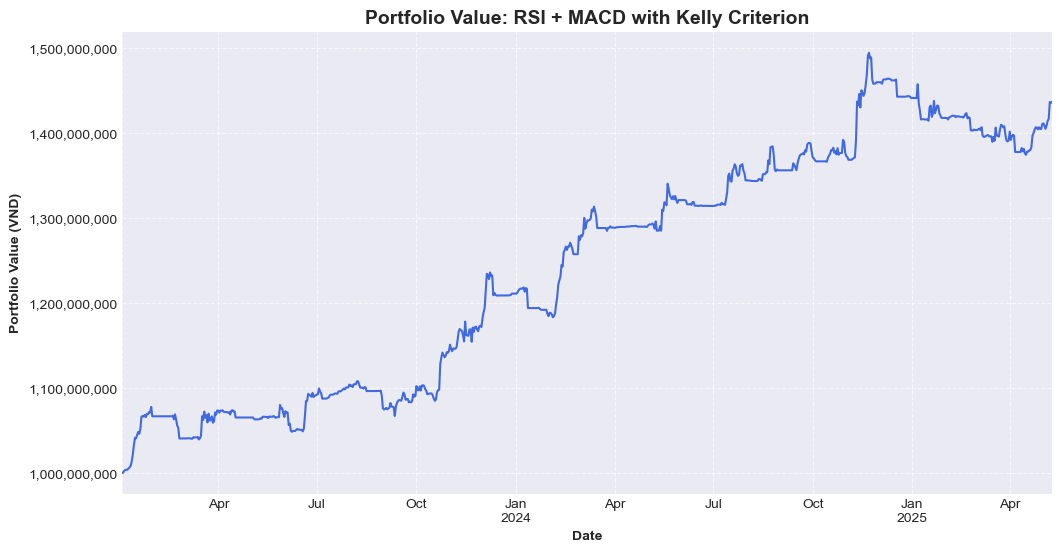


--- Backtesting: RSI + MACD with Equal Weight ---


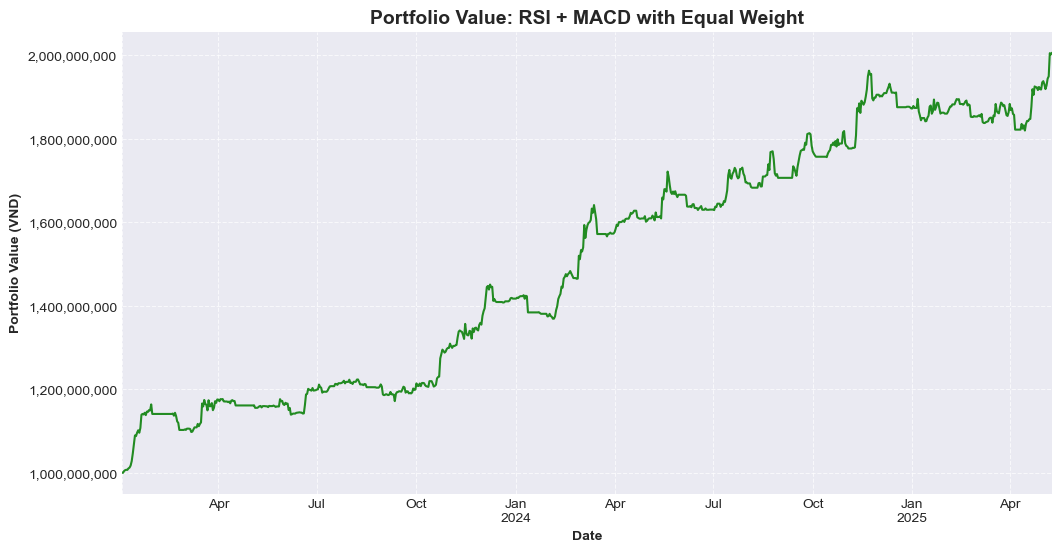


--- Backtesting: RSI + KC with Kelly Criterion ---


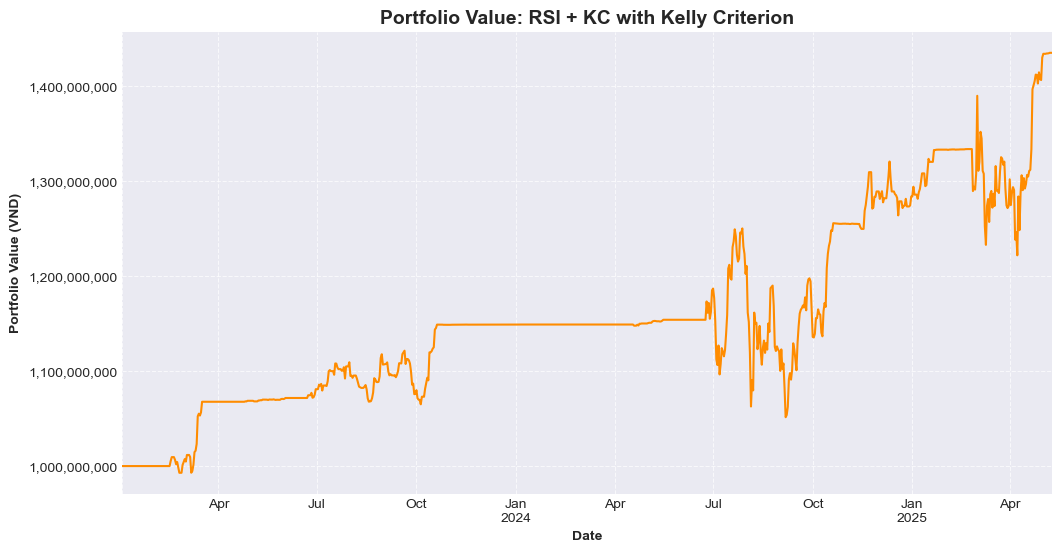


--- Backtesting: RSI + KC with Equal Weight ---


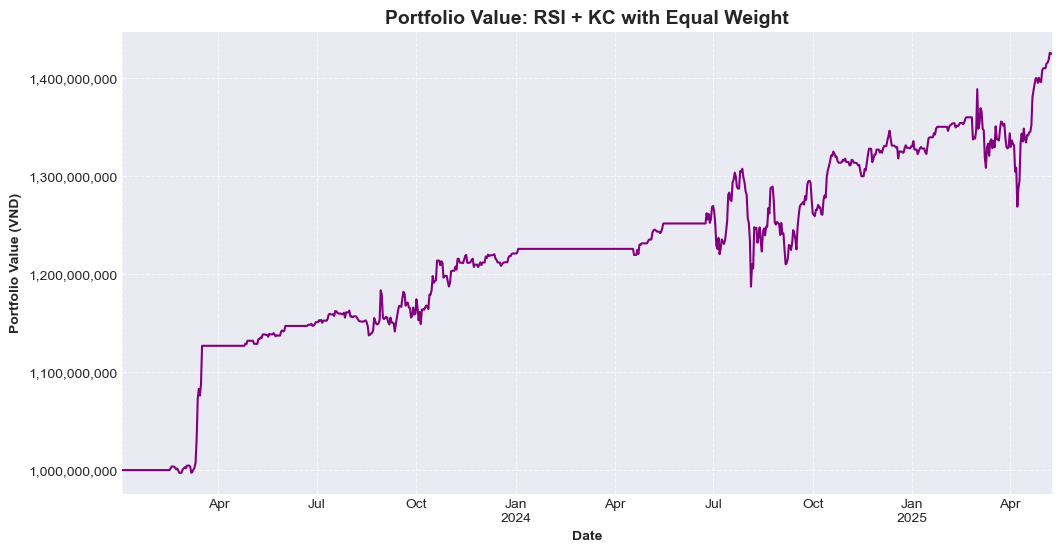



--- Performance Metrics Summary (Backtest Period) ---


,Total Return (%),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%),Avg Daily Return (AR) (%),Avg Profit (AP) (%),Avg Loss (AL) (%),Daily Volatility (VL) (%)
RSI_MACD_Kelly,43.66%,11.20%,7.15%,1.09,-8.03%,0.0431%,0.3507%,-0.2785%,0.4507%
RSI_MACD_EqualWeight,100.61%,22.63%,10.86%,1.65,-7.31%,0.0833%,0.5671%,-0.4554%,0.6843%
RSI_KC_Kelly,43.51%,11.16%,14.71%,0.59,-15.90%,0.0463%,0.6737%,-0.7084%,0.9268%
RSI_KC_EqualWeight,42.49%,10.93%,8.95%,0.86,-9.19%,0.0428%,0.4858%,-0.4296%,0.5636%


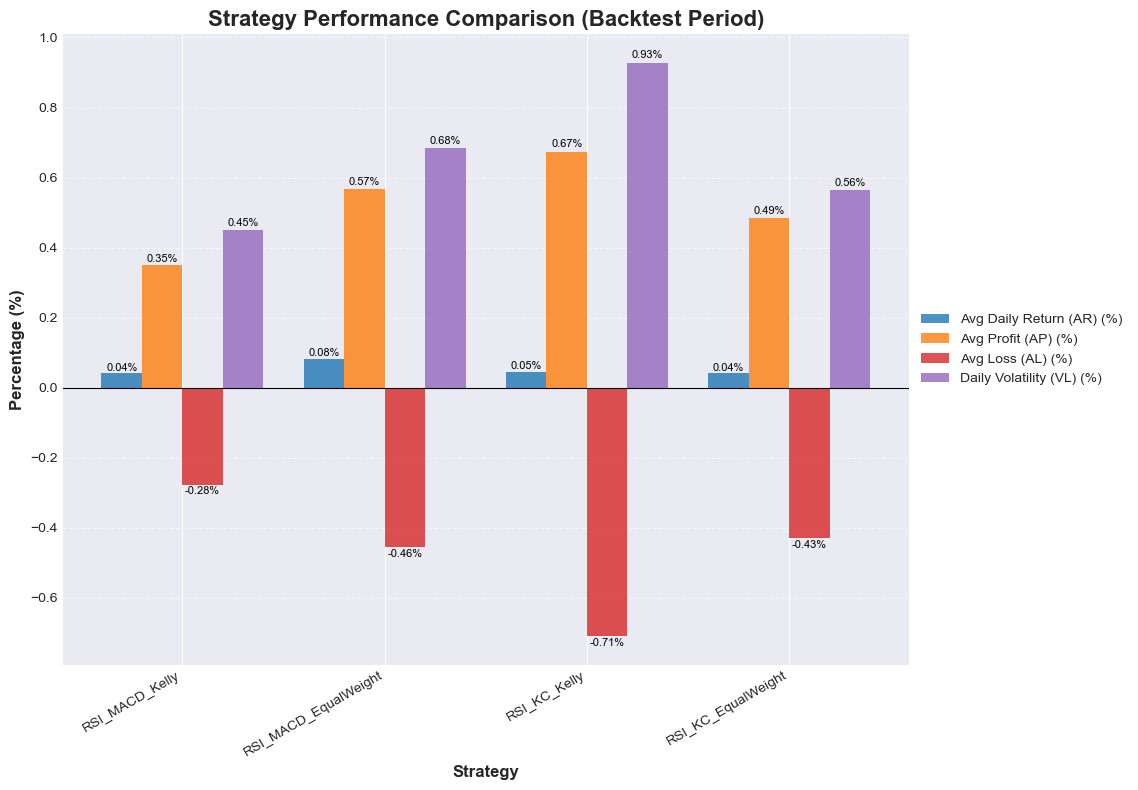



--- Asset Allocation Over Time (Backtest Period) ---


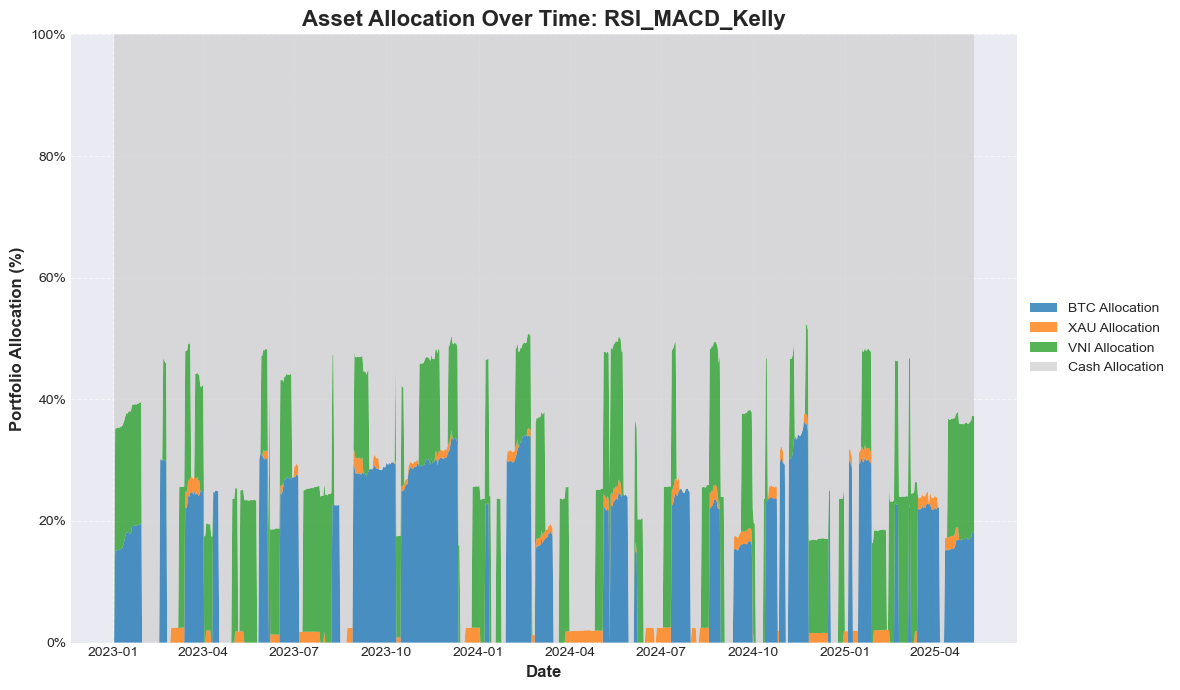

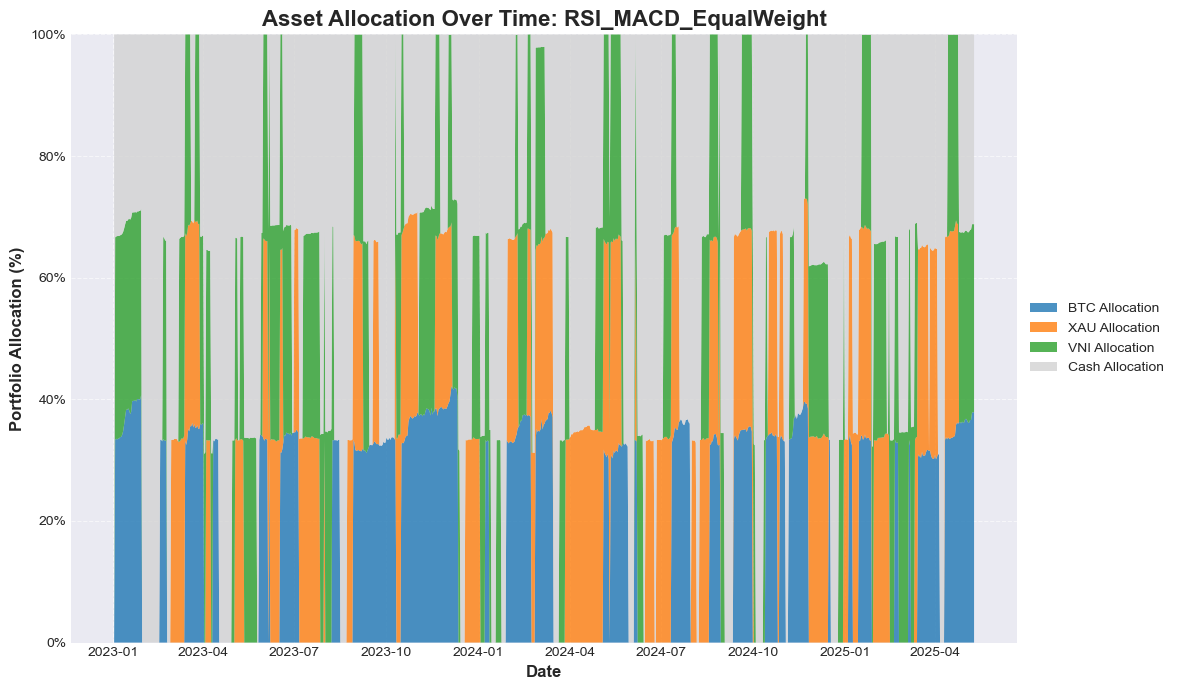

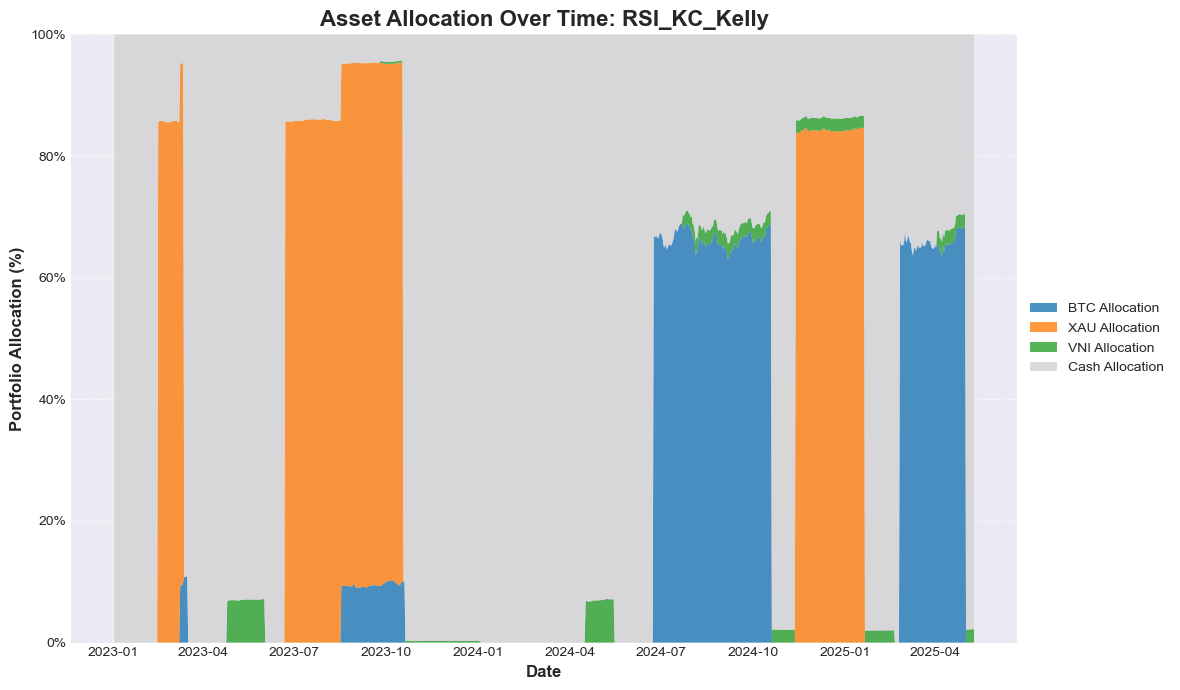

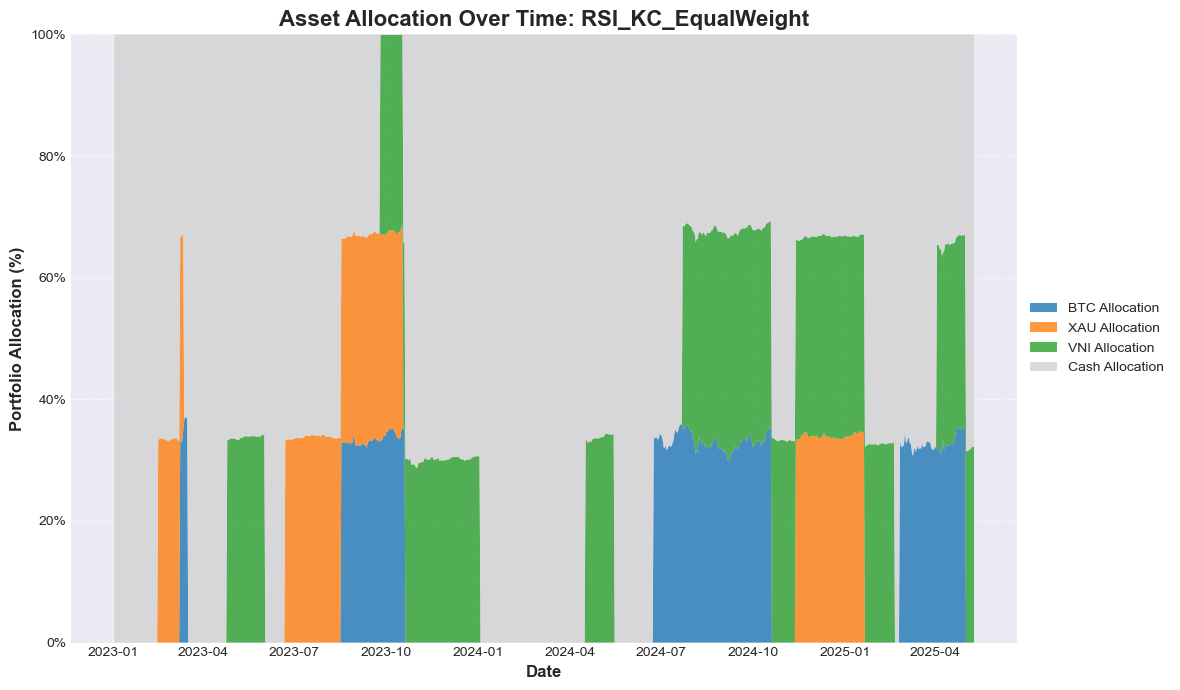

In [8]:
def plot_asset_allocation_over_time(portfolio_df, strategy_title):
    if portfolio_df is None or portfolio_df.empty: print(f"No portfolio data to plot allocation for {strategy_title}"); return
    alloc_df = pd.DataFrame(index=portfolio_df.index)
    alloc_df['BTC'] = (portfolio_df['BTC_Value'] / portfolio_df['Total_Value']) * 100
    alloc_df['XAU'] = (portfolio_df['XAU_Value'] / portfolio_df['Total_Value']) * 100
    alloc_df['VNI'] = (portfolio_df['VNI_Value'] / portfolio_df['Total_Value']) * 100
    alloc_df['Cash'] = (portfolio_df['Cash'] / portfolio_df['Total_Value']) * 100
    alloc_df = alloc_df.replace([np.inf, -np.inf], np.nan).dropna()
    if alloc_df.empty: print(f"No valid allocation data to plot for {strategy_title} after cleaning infinites."); return
    plt.figure(figsize=(14, 7)); colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d3d3d3']; labels = ['BTC Allocation', 'XAU Allocation', 'VNI Allocation', 'Cash Allocation']
    plt.stackplot(alloc_df.index, alloc_df['BTC'], alloc_df['XAU'], alloc_df['VNI'], alloc_df['Cash'], labels=labels, colors=colors, alpha=0.8)
    plt.title(f'Asset Allocation Over Time: {strategy_title}', fontsize=16, fontweight='bold'); plt.xlabel('Date', fontweight='bold', fontsize=12); plt.ylabel('Portfolio Allocation (%)', fontweight='bold', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10); plt.grid(True, linestyle='--', alpha=0.6); plt.ylim(0, 100) 
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter()); plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.show()

results_summary = {}

def style_dataframe(df):
    precision_map = {"Total Return (%)": "{:.2f}%", "Annualized Return (%)": "{:.2f}%", "Annualized Volatility (%)": "{:.2f}%", "Sharpe Ratio": "{:.2f}", "Max Drawdown (%)": "{:.2f}%", "Avg Daily Return (AR) (%)": "{:.4f}%", "Avg Profit (AP) (%)": "{:.4f}%", "Avg Loss (AL) (%)": "{:.4f}%", "Daily Volatility (VL) (%)": "{:.4f}%"}
    styled_df = df.style.format(precision_map).set_caption("Performance Metrics Summary (Backtest Period)") \
                   .set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]}, {'selector': 'th', 'props': [('text-align', 'center')]}, {'selector': 'td', 'props': [('text-align', 'right')]}]) \
                   .highlight_max(axis=0, subset=pd.IndexSlice[:, df.columns.difference(['Avg Loss (AL) (%)', 'Annualized Volatility (%)', 'Daily Volatility (VL) (%)', 'Max Drawdown (%)'])], color='#d4edda') \
                   .highlight_min(axis=0, subset=pd.IndexSlice[:, df.columns.difference(['Avg Loss (AL) (%)', 'Annualized Volatility (%)', 'Daily Volatility (VL) (%)', 'Max Drawdown (%)'])], color='#f8d7da') \
                   .highlight_min(axis=0, subset=['Avg Loss (AL) (%)', 'Annualized Volatility (%)', 'Daily Volatility (VL) (%)', 'Max Drawdown (%)'], color='#d4edda') 
    return styled_df

def plot_performance_bars(results_df_input, title="Strategy Performance Comparison (Backtest Period)"):
    metrics_to_plot = ['Avg Daily Return (AR) (%)', 'Avg Profit (AP) (%)', 'Avg Loss (AL) (%)', 'Daily Volatility (VL) (%)']
    actual_metrics_to_plot = [m for m in metrics_to_plot if m in results_df_input.columns]
    if not actual_metrics_to_plot: print("None of the specified metrics for bar chart are available."); return
    plot_df = results_df_input[actual_metrics_to_plot].copy(); n_strategies = len(plot_df.index); n_metrics_to_display = len(actual_metrics_to_plot) 
    bar_width = 0.8 / n_metrics_to_display; index_positions = np.arange(n_strategies)
    fig, ax1 = plt.subplots(figsize=(14, 8)); colors = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd']
    for i, metric in enumerate(actual_metrics_to_plot):
        bar_values = plot_df[metric].fillna(0); bar_positions = index_positions - (bar_width * (n_metrics_to_display -1) / 2) + (i * bar_width)
        bars = ax1.bar(bar_positions, bar_values, bar_width, label=metric, color=colors[i % len(colors)], alpha=0.8)
        for bar in bars:
            yval = bar.get_height(); text_y_offset = 0.01 * np.sign(yval) if yval != 0 else 0.01; va = 'bottom' if yval >= 0 else 'top'
            if pd.notna(yval): ax1.text(bar.get_x() + bar.get_width()/2.0, yval + text_y_offset * abs(yval), f'{yval:.2f}%', ha='center', va=va, fontsize=8, color='black', fontweight='medium')
    ax1.set_xlabel('Strategy', fontweight='bold', fontsize=12); ax1.set_ylabel('Percentage (%)', fontweight='bold', fontsize=12)
    ax1.set_title(title, fontsize=16, fontweight='bold'); ax1.set_xticks(index_positions) 
    ax1.set_xticklabels(plot_df.index, rotation=30, ha="right", fontsize=10) 
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10); ax1.grid(True, linestyle='--', alpha=0.6, axis='y') 
    ax1.axhline(0, color='black', linewidth=0.8); ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 0.82, 1]); plt.show()

def display_kelly_parameters_table(kelly_params_dict_input):
    if not kelly_params_dict_input: print("Kelly parameters dictionary is empty."); return
    table_data = []
    for asset, strategies_params in kelly_params_dict_input.items():
        for strategy_name, params in strategies_params.items(): table_data.append({'Asset': asset, 'Strategy': strategy_name, 'Winning Rate (p)': params.get('p', np.nan) * 100, 'Decimal Odds (b)': params.get('b', np.nan)})
    df_kelly_table = pd.DataFrame(table_data)
    if df_kelly_table.empty: print("No Kelly parameters to display."); return
    styled_table = df_kelly_table.style.format({'Winning Rate (p)': '{:.2f}%', 'Decimal Odds (b)': '{:.2f}'}).set_caption("Kelly Criterion Parameters (Training Period)") \
      .set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '14px'), ('font-weight', 'bold')]}, {'selector': 'th', 'props': [('background-color', '#e9ecef'), ('text-align', 'center'), ('font-weight', 'bold')]}, {'selector': 'td', 'props': [('text-align', 'center')]}, {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}]) \
      .hide(axis="index") 
    from IPython.display import display, HTML; display(HTML(styled_table.to_html()))

if data_with_indicators is not None and not data_with_indicators.empty and (kelly_params_dict and any(kelly_params_dict.values())): 
    print("\n--- Kelly Criterion Parameters (Training Period) ---")
    display_kelly_parameters_table(kelly_params_dict)
    strategy_results_dfs = {} 
    # Chiến lược 1: RSI + MACD
    print("\n--- Backtesting: RSI + MACD with Kelly Criterion ---")
    portfolio_rsi_macd_kelly = run_backtest(data_with_indicators, INITIAL_CAPITAL, 'RSI_MACD', 'kelly', kelly_params_dict)
    strategy_results_dfs['RSI_MACD_Kelly'] = portfolio_rsi_macd_kelly
    if portfolio_rsi_macd_kelly is not None and not portfolio_rsi_macd_kelly.empty:
        metrics_rsi_macd_kelly = calculate_performance_metrics(portfolio_rsi_macd_kelly, INITIAL_CAPITAL, ANNUAL_RISK_FREE_RATE)
        results_summary['RSI_MACD_Kelly'] = metrics_rsi_macd_kelly
        plt.figure(figsize=(12,6)); portfolio_rsi_macd_kelly['Total_Value'].plot(color='royalblue', linewidth=1.5)
        plt.title('Portfolio Value: RSI + MACD with Kelly Criterion', fontsize=14, fontweight='bold'); plt.ylabel("Portfolio Value (VND)", fontweight='bold'); plt.xlabel("Date", fontweight='bold')
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ','))); plt.grid(True, linestyle='--', alpha=0.7); plt.show()
    else: print("No results for RSI + MACD with Kelly.")
    print("\n--- Backtesting: RSI + MACD with Equal Weight ---")
    portfolio_rsi_macd_equal = run_backtest(data_with_indicators, INITIAL_CAPITAL, 'RSI_MACD', 'equal_weight', kelly_params_dict)
    strategy_results_dfs['RSI_MACD_EqualWeight'] = portfolio_rsi_macd_equal
    if portfolio_rsi_macd_equal is not None and not portfolio_rsi_macd_equal.empty:
        metrics_rsi_macd_equal = calculate_performance_metrics(portfolio_rsi_macd_equal, INITIAL_CAPITAL, ANNUAL_RISK_FREE_RATE)
        results_summary['RSI_MACD_EqualWeight'] = metrics_rsi_macd_equal
        plt.figure(figsize=(12,6)); portfolio_rsi_macd_equal['Total_Value'].plot(color='forestgreen', linewidth=1.5)
        plt.title('Portfolio Value: RSI + MACD with Equal Weight', fontsize=14, fontweight='bold'); plt.ylabel("Portfolio Value (VND)", fontweight='bold'); plt.xlabel("Date", fontweight='bold')
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ','))); plt.grid(True, linestyle='--', alpha=0.7); plt.show()
    else: print("No results for RSI + MACD with Equal Weight.")
    
    # Chiến lược 2: RSI + KC (Keltner Channels)
    can_run_rsi_kc = all('RSI_KC' in kelly_params_dict.get(asset, {}) for asset in ['BTC', 'XAU', 'VNI']) and ('RSI_KC' in strategies_for_kelly) 
    if can_run_rsi_kc:
        print("\n--- Backtesting: RSI + KC with Kelly Criterion ---")
        portfolio_rsi_kc_kelly = run_backtest(data_with_indicators, INITIAL_CAPITAL, 'RSI_KC', 'kelly', kelly_params_dict)
        strategy_results_dfs['RSI_KC_Kelly'] = portfolio_rsi_kc_kelly # Đổi tên key
        if portfolio_rsi_kc_kelly is not None and not portfolio_rsi_kc_kelly.empty:
            metrics_rsi_kc_kelly = calculate_performance_metrics(portfolio_rsi_kc_kelly, INITIAL_CAPITAL, ANNUAL_RISK_FREE_RATE)
            results_summary['RSI_KC_Kelly'] = metrics_rsi_kc_kelly # Đổi tên key
            plt.figure(figsize=(12,6)); portfolio_rsi_kc_kelly['Total_Value'].plot(color='darkorange', linewidth=1.5)
            plt.title('Portfolio Value: RSI + KC with Kelly Criterion', fontsize=14, fontweight='bold'); plt.ylabel("Portfolio Value (VND)", fontweight='bold'); plt.xlabel("Date", fontweight='bold')
            plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ','))); plt.grid(True, linestyle='--', alpha=0.7); plt.show()
        else: print("No results for RSI + KC with Kelly.")
        
        print("\n--- Backtesting: RSI + KC with Equal Weight ---")
        portfolio_rsi_kc_equal = run_backtest(data_with_indicators, INITIAL_CAPITAL, 'RSI_KC', 'equal_weight', kelly_params_dict)
        strategy_results_dfs['RSI_KC_EqualWeight'] = portfolio_rsi_kc_equal # Đổi tên key
        if portfolio_rsi_kc_equal is not None and not portfolio_rsi_kc_equal.empty:
            metrics_rsi_kc_equal = calculate_performance_metrics(portfolio_rsi_kc_equal, INITIAL_CAPITAL, ANNUAL_RISK_FREE_RATE)
            results_summary['RSI_KC_EqualWeight'] = metrics_rsi_kc_equal # Đổi tên key
            plt.figure(figsize=(12,6)); portfolio_rsi_kc_equal['Total_Value'].plot(color='purple', linewidth=1.5)
            plt.title('Portfolio Value: RSI + KC with Equal Weight', fontsize=14, fontweight='bold'); plt.ylabel("Portfolio Value (VND)", fontweight='bold'); plt.xlabel("Date", fontweight='bold')
            plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ','))); plt.grid(True, linestyle='--', alpha=0.7); plt.show()
        else: print("No results for RSI + KC with Equal Weight.")
    else: print("\nCannot run backtest for RSI + KC strategy.")

    if results_summary:
        print("\n\n--- Performance Metrics Summary (Backtest Period) ---")
        results_df = pd.DataFrame(results_summary).T 
        results_df_renamed = results_df.rename(columns={"Avg Daily Portfolio Return (AR) (%)": "Avg Daily Return (AR) (%)", "Avg Profit (AP) (Positive Days) (%)": "Avg Profit (AP) (%)", "Avg Loss (AL) (Negative Days) (%)": "Avg Loss (AL) (%)", "Volatility of Daily Returns (VL) (%)": "Daily Volatility (VL) (%)"})
        from IPython.display import display, HTML; display(HTML(style_dataframe(results_df_renamed).to_html())) 
        metrics_for_bar_chart = ['Avg Daily Return (AR) (%)', 'Avg Profit (AP) (%)', 'Avg Loss (AL) (%)', 'Daily Volatility (VL) (%)']
        if all(metric in results_df_renamed.columns for metric in metrics_for_bar_chart): plot_performance_bars(results_df_renamed, title="Strategy Performance Comparison (Backtest Period)")
        else: print("\nCould not generate performance bar chart due to missing columns.")
        print("\n\n--- Asset Allocation Over Time (Backtest Period) ---")
        for strat_title, portfolio_data in strategy_results_dfs.items(): plot_asset_allocation_over_time(portfolio_data, strat_title)
    else: print("\nNo results to summarize.")
else: print("Cannot perform backtesting.")

### 8.6 Explain the results
#### 8.6.1 Kelly parameters
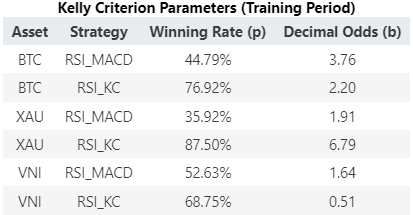

* **Winning Rate (p) %**: The percentage of trades that were profitable.
* **Decimal Odds (b)**: The average amount won on a winning trade divided by the average amount lost on a losing trade.
Eg: BTC - RSI_MACD: This strategy has a win rate of 44.79% and when winning it make 3.76 times more money than losing trade, on average

#### 8.6.2 Analysis about Performance of the strategies
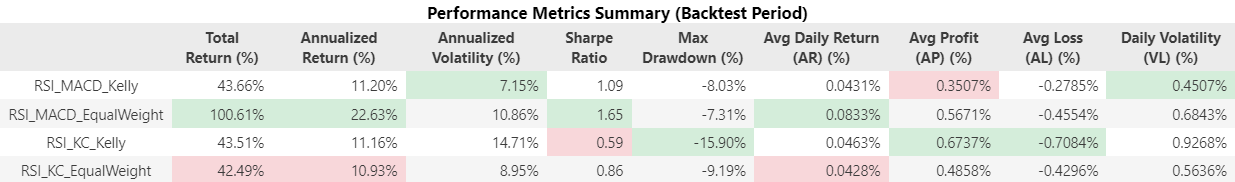

An examination of the Profit and Loss (PnL) trajectories for the four implemented strategies reveals that all strategies generated positive returns during the backtesting period from early 2023 to mid-2025. However, distinct differences in performance characteristics and risk profiles were observed.

The PnL curve for the RSI-MACD (momentum) strategies generally appears smoother compared to that of the RSI-Keltner Channel (mean reversion) strategies. Notably, the RSI-KC strategies exhibited periods where their PnL lines remained flat. This suggests a lower trading frequency for these strategies, which is corroborated by an analysis of portfolio asset allocation, showing periods where the entire portfolio held a 0% allocation to the traded assets (~fully in cash).

Overall, the momentum strategy utilizing `RSI_MACD` demonstrated superior performance compared to the mean-reversion strategy employing `RSI_KC` during the specified backtest period (January 2, 2023 - May 10, 2025). This outperformance can likely be attributed to the market conditions and the nature of the assets (BTC, XAU, VNI). These assets experienced strong volatility and clear upward trends during this period. 
=> Mean-reversion strategies, which typically generate counter-trend signals, may struggle in such trending environments, potentially leading to larger drawdowns as they attempt to trade against the prevailing price direction.

Among the four strategies, the **RSI-MACD with Equal Weight** allocation emerged as the top performer, achieving the highest returns and the best risk-adjusted performance, coupled with the lowest drawdown.

An interesting observation arises when comparing the impact of the Kelly Criterion on the two signal strategies:

* For the **RSI-MACD strategy**, applying the Kelly Criterion resulted in a slight **decrease in portfolio volatility** compared to its Equal Weight counterpart.
* Conversely, for the **RSI-KC strategy**, the application of the Kelly Criterion led to a **significant increase in both volatility and maximum drawdown**.

This divergence in the Kelly Criterion's impact can be explained by how it allocates capital based on the pre-calculated `p` (winning rate) and `b` (decimal odds) parameters from the training period.

It's plausible that for the RSI-MACD strategy, the Kelly parameters for Gold (an asset potentially with lower win rates or odds with this strategy) resulted in a smaller allocation to it, thereby reducing overall portfolio volatility.
However, for the RSI-KC strategy, in the training period yielded overly optimistic Kelly parameters for Gold during, the Kelly Criterion would have dictated a very high capital allocation to these assets. If these assets then underperformed or experienced significant downturns during the backtest period, such concentrated high-Kelly-fraction positions would naturally lead to increased portfolio volatility and larger drawdowns, as observed. This highlights the sensitivity of the Kelly Criterion to the accuracy and stationarity of its input parameters.